In [21]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

from sklearn.externals import joblib

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2
from keras.models import load_model

from glob import glob

import matplotlib 

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### show the experimental data
#### define inputs (filenames, calibration, etc.)

In [16]:
filename_esr = '../data_exp/190122-15_41_20_esr_many_on_alice_wider_range_center_0_0_esr_map.h5'
filename_pos = '../data_exp/190122-15_40_40_select_points'
calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

h5f = h5py.File(filename_esr, 'r')
esr_map = np.array(h5f['esr_map'])
frequencies = np.array(h5f['frequency'])
h5f.close()

the calibration factor is 659.259 micrometers / volt


[168.  80. 288.  48. 328.  32. 248.  24. 136. 280. 112. 176. 104. 312.
 184.  88. 208.  16.  64. 272. 128. 240. 304. 336.   0. 192. 344. 256.
 152.  56. 264. 352. 120.  72. 200. 224. 144.   8. 160. 320. 296. 216.
  40. 232.  96.]
the radius is 63.302 micrometers


Text(0, 0.5, 'y (um)')

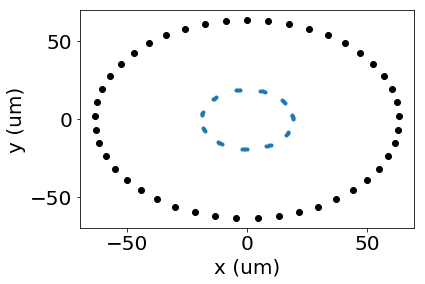

In [31]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um
angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad
print(angles)
nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
print('the radius is {:0.3f} micrometers'.format(radius))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

In [32]:
angles

array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
       264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
       352.])

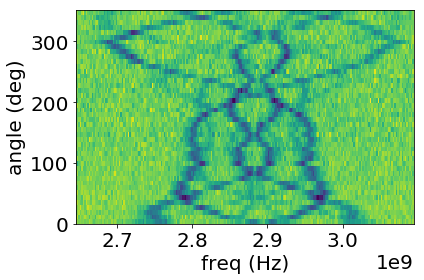

In [33]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.pcolor(frequencies, angles, esr_map)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

The noise is $n = \sqrt{c \tau}$, where $s = c \tau$ are the number of photons collected. Thus, the normalized noise is

$$n_{\rm norm} = n/s =  1 / \sqrt{c \tau}$$,

where $c$ is the count rate and $\tau$ the measurement time.

### Look at the noise

the noise level is 0.0012. Thus for count rate 1000, the measurement time is 642


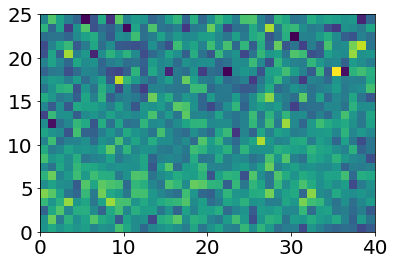

In [35]:
noise = np.std(esr_map[:25, 0:40])

plt.pcolor(esr_map[:25, 0:40])
print('the noise level is {:0.4f}. Thus for count rate 1000, the measurement time is {:0.0f}'.format(noise, 1/(1000*noise**2)))

### fit model

**show available models**

In [40]:
[f.split('/')[-1].split('_model.h5')[0] for f in glob('../models/*model*.h5')]

['shot_noise_2_xyzt']

## load the model

In [39]:
tag = 'shot_noise_2_xyzt'  # tage for the trained model that we use to fit the data

model = load_model('../models/'+tag+'_model.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 43, 349, 64)       640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 174, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 172, 128)      73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 86, 128)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 84, 256)        295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 82, 256)        590080    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 41, 256)        0         
__________

In [48]:
X = esr_map.reshape(1, *esr_map.shape,1)
X.shape

(1, 45, 226, 1)

In [49]:
Y_predict = model.predict(X)

ValueError: Error when checking input: expected conv2d_5_input to have shape (45, 351, 1) but got array with shape (45, 226, 1)

(45, 226, 1)